In [1]:
# Necessary libraries.
import numpy as np                             # library for numerical operations.
import matplotlib.pyplot as plt                # library for plotting.
import matplotlib as mpl                       # library for plotting.
import torch                                   # library for tensor operations.
from nltk.tokenize import TweetTokenizer       # library for tweet tokenization.
from nltk.corpus import stopwords              # library for stopwords.
stopwords_es = set(stopwords.words('spanish')) # set of spanish stopwords.
import os                                      # library for operating system.
import time                                    # library for time.
from typing import Tuple, Callable, List       # library for typing.
import random                                  # library for random numbers.
import pandas as pd                            # library for data manipulation.
from collections import defaultdict, Counter   # library for collections.
from tqdm import tqdm                          # library for progress bar.
import torch.nn as nn                          # library for neural network operations.
import torch.nn.functional as F                # library for functional operations.
from torch.utils.data import (DataLoader,      # library for data loading.
                              Dataset)         # library for dataset.
from sklearn.metrics import (confusion_matrix,      # library for evaluation.
                             classification_report, # library for evaluation.
                             f1_score)              # library for evaluation.
from torch import optim                        # for neural networks.
from colorama import Fore, Style               # library for colored text.
import seaborn as sns                          # library for data visualization.
sns.set_style("darkgrid")                      # set style for seaborn.
import xml.etree.ElementTree as ET             # library for xml parsing.
from IPython.display import display, HTML      # library for displaying HTML.
np.random.seed(0)                              # seed for reproducibility.
random.seed(0)                                 # seed for reproducibility.
torch.manual_seed(0)                           # seed for reproducibility.
torch.backends.cudnn.benchmark = False         # reproducibility.

Systems are evaluated using standard evaluation metrics, including precision, recall, and F1-score. How each task will be evaluated is listed below:

1. For this edition, *Equation 1* is applyed to evaluate the result of the **polarity classification**. Where $k$ is a forum participant system, $C = \{1,2,3,4,5\}$. Finally, $F_i(K)$ is the F-measure value for the class $i$ obtained by the system $k$.
$$
Res_P(k) = \frac{\sum_{i=1}^{|C|} F_i(k)}{|C|}
$$

2. For the **Type prediction**, there are $3$ classes (*Attractive, Hotel, and Restaurant*). For this reason, we apply the Macro F-measure as the *Equation 2* indicates. Where
    - $F_A(k)$ represents the F measure obtained by the system $k$ for the **Attractive class**.
    - $F_H(k)$ represents the F measure obtained by the system $k$ for the **Hotel class**.
    - In the same way, $F_R(k)$ represents the F measure obtained by the system $k$ for the **Restaurant class**.
$$
Res_T(k) = \frac{F_A(k) + F_H(k) + F_R(k)}{3}
$$
    
3. For the evaluation of the **Magical Town (MT)** task, the idea is similar to the type prediction measure. For this, we suppose that there exists a list with all Magical Towns named MTL (Magical Towns list). The *Equation 3* shows this classification measure. 
$$
Res_{MT}(k) = \frac{\sum_{i=1}^{len(MTL)} F_{MTL_{i}} (k)}{len(MTL)}
$$

The final measure for this task is the average of $3$ sub-tasks. The idea is that polarity and the Magical Town identification have more weight than the other subtask, it will be given two and three times the importance, respectively, as we can see in the *Equation 4*:
$$
Sentiment(k) = \frac{2*Res_P(k) + Res_T(k) + 3*Res_{MT}(k)}{6}
$$

In [2]:
# Necessary libraries.
import numpy as np                             # library for numerical operations.
import matplotlib.pyplot as plt                # library for plotting.
from nltk.tokenize import TweetTokenizer       # library for tweet tokenization.
from nltk.corpus import stopwords              # library for stopwords.
stopwords_es = set(stopwords.words('spanish')) # set of spanish stopwords.
import time                                    # library for time.
from typing import Tuple, Callable, List       # library for typing.
import random                                  # library for random numbers.
from sklearn.metrics import classification_report
import pandas as pd                            # library for data manipulation.
#
# from tqdm.notebook import tqdm                 # library for progress bar.
from sklearn.metrics import accuracy_score     # library for accuracy score.
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix # library for evaluation.
from colorama import Fore, Style               # library for colored text.
from sklearn.metrics import f1_score           # for evaluation.
import csv
import copy                                    # library for copying.
from itertools import permutations             # library for permutations.
import seaborn as sns                          # library for data visualization.
sns.set_style("darkgrid")                      # set style for seaborn.
import re, unicodedata
import xml.etree.ElementTree as ET             # library for xml parsing.
np.random.seed(0)                              # seed for reproducibility.
random.seed(0)                                 # seed for reproducibility.

import torch
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import normalized_mutual_info_score
from torch.utils.data import DataLoader as TorchDataLoader
from sklearn.feature_selection import mutual_info_classif, chi2

#import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib import colormaps
from matplotlib.colors import LogNorm

import torch.nn as nn

from torch.utils.data import (DataLoader,      # library for data loading.
                              TensorDataset,   # library for tensor dataset.
                              Dataset)         # library for dataset.
import sys 
import os
from wordcloud import WordCloud                # library for wordcloud.
from sklearn.model_selection import StratifiedShuffleSplit

# **SRP**

### **Métodos auxiliares**

In [3]:
class NameFormatter:
    
    @staticmethod
    def name_formatter(name: str) -> str:
        name_map = {
            'QuintanaRoo'        : 'Quintana Roo',
            'Michoacan'          : 'Michoacán',
            'Yucatan'            : 'Yucatán',
            'Queretaro'          : 'Querétaro',
            'Baja_CaliforniaSur' : 'Baja California Sur',
            'San_Luis_Potosi'    : 'San Luis Potosí',
            'Estado_de_Mexico'   : 'Estado de México',
            'TodosSantos'        : 'Todos Santos',
            'Patzcuaro'          : 'Pátzcuaro',
            'Teotihuacan'        : 'Teotihuacán',
            'Tepoztlan'          : 'Tepoztlán',
            'Cuatro_Cienegas'    : 'Cuatro Ciénegas',
            'Tepotzotlan'        : 'Tepotzotlán',
            'Zacatlan'           : 'Zacatlán',
        }
        if name in name_map:
            return name_map[name]
        elif '_' in name:
            return name.replace('_', ' ').title()        
        else:
            return name
        
def collate_fn(batch):
    input_ids, lengths, polarities, towns, place_types = zip(*batch)
    input_ids = torch.stack(input_ids)
    lengths = torch.tensor(lengths)
    polarities = torch.stack(polarities)
    return input_ids, lengths, polarities, towns, place_types

def collate_fn_hierarchical(batch):
    """
    batch: List of tuples (input_ids, length, polarity, town, type)
    agrupado por town
    """
    grouped = defaultdict(list)
    for input_ids, length, polarity, town, place_type in batch:
        grouped[town].append((input_ids, length, polarity, place_type))

    towns = list(grouped.keys())
    max_reviews = max(len(reviews) for reviews in grouped.values())
    max_len = max(len(ids) for reviews in grouped.values() for ids, _, _, _ in reviews)

    batch_input_ids = []
    batch_lengths = []
    batch_polarities = []
    batch_types = []

    for town in towns:
        reviews = grouped[town]
        padded_input_ids = []
        lengths = []
        polarities = []
        types = []

        for ids, length, polarity, place_type in reviews:
            pad_len = max_len - len(ids)
            padded = torch.cat([ids, torch.tensor([0] * pad_len)])  # pad token ID = 0
            padded_input_ids.append(padded)
            lengths.append(length)
            polarities.append(polarity)
            types.append(place_type)

        # Si hay menos reseñas que el máximo del batch → pad con reseñas vacías
        while len(padded_input_ids) < max_reviews:
            padded_input_ids.append(torch.zeros(max_len, dtype=torch.long))
            lengths.append(0)
            polarities.append(torch.tensor(0.))  # dummy
            types.append("None")

        batch_input_ids.append(torch.stack(padded_input_ids))
        batch_lengths.append(torch.tensor(lengths))
        batch_polarities.append(torch.stack(polarities))
        batch_types.append(types)

    input_ids = torch.stack(batch_input_ids)       # (batch_size, n_reviews, n_tokens)
    lengths = torch.stack(batch_lengths)           # (batch_size, n_reviews)
    polarities = torch.stack(batch_polarities)     # (batch_size, n_reviews)
    
    return input_ids, lengths, polarities, batch_types, towns

### **Carga de datos**

In [4]:
class DataLoader2:
    """
    DataLoader class for loading and processing data from a CSV file. This class reads the data from a CSV
    file, adds a sentiment column based on the polarity, and provides methods to extract reviews and labels.
    """
    def __init__(self, data_path: str):
        """
        Initialize the DataLoader with the path to the data file.

        Parameters
        ----------
        data_path : str
            Path to the CSV file containing the data.
        """
        self.data_path = data_path
        self.data = self._read_data()
        self._add_sentiment_column()

    def _read_data(self) -> pd.DataFrame:
        """
        Read the data from the CSV file.
        """
        return pd.read_csv(self.data_path)

    def _add_sentiment_column(self):
        """
        Add a sentiment column to the DataFrame based on the polarity.
        """
        self.data['Sentiment'] = self.data['Polarity'].apply(
            lambda x: 'Positive' if x >= 4 else 'Neutral' if x == 3 else 'Negative'
        )

    def get_data(self) -> pd.DataFrame:
        """Return a copy of the DataFrame."""
        return self.data.copy()
    
class ReviewLabelExtractor:
    """
    ReviewLabelExtractor class for extracting reviews and labels from a DataFrame. This class takes a DataFrame
    as input and provides a method to extract reviews and labels. The reviews are extracted from the 'Review'
    column and the labels are extracted from the 'Polarity', 'Town', and 'Type' columns. The labels are returned
    as a list of tuples.
    """
    def __init__(self, df: pd.DataFrame):
        """
        Initialize the ReviewLabelExtractor with a DataFrame.
        
        Parameters
        ----------
        df : pd.DataFrame
            DataFrame containing the data. The DataFrame should contain the columns 
                'Review', 'Polarity', 'Town', 'Type'.
        """
        self.df = df

    def extract(self) -> Tuple[List[str], List[Tuple[float, str, str]]]:
        """
        Extract reviews and labels from the DataFrame.
        
        Returns
        -------
        reviews : List[str]
            List of reviews extracted from the 'Review' column of the DataFrame.
        labels : List[Tuple[float, str, str]]
            List of tuples containing the polarity, town, and type extracted from the 'Polarity', 'Town', and
            'Type' columns of the DataFrame. The tuples are in the format (polarity, town, type).
        """
        reviews = self.df['Review'].fillna('').tolist()
        labels = list(zip(
            self.df['Polarity'].astype(float),
            self.df['Town'].str.strip(),
            self.df['Type'].str.strip()
        ))
        return reviews, labels

### **Procesamiento de texto**

In [5]:
class TextPreprocessor:
    """
    TextPreprocessor class for preprocessing text data. This class takes a tokenizer and a set of stopwords
    as input and provides a method to process text data. The text data is tokenized, converted to lowercase,
    and stopwords are removed. The processed text data is returned as a list of tokens.
    """
    def __init__(self, tokenizer: Callable = None, stopwords: set = None):
        """
        Initialize the TextPreprocessor with a tokenizer and a set of stopwords.
        
        Parameters
        ----------
        tokenizer : Callable, optional
            Tokenizer function to use for tokenizing the text data. If None, the default tokenizer is used.
        stopwords : set, optional
            Set of stopwords to remove from the text data. If None, no stopwords are removed.
        """
        self.tokenizer = tokenizer or TweetTokenizer().tokenize
        self.stopwords = stopwords or set()

    def process(self, text: str) -> List[str]:
        """
        Process the text data by tokenizing, converting to lowercase, and removing stopwords.

        Parameters
        ----------
        text : str
            Text data to process.

        Returns
        -------
        tokens : List[str]
            List of tokens extracted from the text data. The tokens are in lowercase and stopwords are removed.
        """
        tokens = self.tokenizer(text.lower())
        return [t for t in tokens if t.isalpha() and t not in self.stopwords]

### **Embeddings**

In [6]:
class EmbeddingLoader:
    """
    EmbeddingLoader class for loading word embeddings from a file. This class takes the path to the embeddings
    file as input and provides a method to load the embeddings. The embeddings are loaded into a vocabulary
    dictionary and an embedding matrix. The vocabulary dictionary maps words to their corresponding indices
    in the embedding matrix. The embedding matrix contains the word embeddings for each word in the vocabulary.
    """
    def __init__(self, embeddings_path: str):
        """
        Initialize the EmbeddingLoader with the path to the embeddings file.

        Parameters
        ----------
        embeddings_path : str
            Path to the file containing the word embeddings. The file should be in the format:
                word1 embedding1
                word2 embedding2
                ...
        """
        self.embeddings_path = embeddings_path

    def load(self) -> Tuple[dict, np.ndarray]:
        """
        Load the word embeddings from the file and return the vocabulary and embedding matrix.

        Returns
        -------
        vocab : dict
            Dictionary mapping words to their corresponding indices in the embedding matrix.
        emb_mat : np.ndarray
            Embedding matrix containing the word embeddings for each word in the vocabulary.
        """
        vocab = {}
        embeddings_list = []
        with open(self.embeddings_path, 'r') as f:
            for i, line in enumerate(f):
                if i == 0:
                    continue
                values = line.split()
                vocab[values[0]] = i + 1
                embeddings_list.append(np.asarray(values[1:], dtype = 'float32'))
        embeddings_list.insert(0, np.mean(np.vstack(embeddings_list), axis = 0)) # Mean vector for unk
        embeddings_list.insert(0, np.zeros(100))                                 # Padding vector
        vocab['pad'] = 0
        vocab['unk'] = 1
        emb_mat = np.vstack(embeddings_list)
        return vocab, emb_mat

### **Dataset para PyTorch**

In [7]:
class ReviewDataset(Dataset):
    """
    ReviewDataset class for creating a dataset from corpus and labels. This class takes a list of corpus,
    a list of labels, a vocabulary dictionary, and a text preprocessor as input. The corpus are tokenized
    and converted to indices using the vocabulary dictionary. The labels are returned as tensors. The dataset
    can be used with a DataLoader for batching and shuffling.
    """
    def __init__(self, corpus: List[str], labels: List[Tuple[int, str, str]],
                 vocab: dict, processor: TextPreprocessor, max_len: int = 10000):
        """
        Initialize the ReviewDataset with corpus, labels, vocabulary, and text preprocessor.
        """
        self.corpus = corpus
        self.labels = labels
        self.vocab = vocab
        self.processor = processor
        self.max_len = max_len

    def __len__(self) -> int:
        """
        Return the number of corpus in the dataset.
        """
        return len(self.corpus)

    def __getitem__(self, idx) -> Tuple[torch.Tensor, int, torch.Tensor, str, str]:
        tokens = self.processor.process(self.corpus[idx])
        ids = [self.vocab.get(t, self.vocab['unk']) for t in tokens[:self.max_len]]
        length = len(ids)
        ids += [self.vocab['pad']] * (self.max_len - length)
        polarity, town, place_type = self.labels[idx]
        return torch.tensor(ids), length, torch.tensor(polarity), town, place_type

In [8]:
class DatasetSplitter:
    def __init__(self, reviews: List[str], labels: List[Tuple[float, str, str]]):
        self.reviews = reviews
        self.labels = labels
        self.polarities = [int(p[0]) for p in labels]  # para estratificar

    def stratified_split(
        self,
        vocab: dict,
        processor,
        test_size: float = 0.2,
        random_state: int = 42,
        max_len: int = 10000
    ) -> Tuple[ReviewDataset, ReviewDataset]:

        splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
        for train_idx, val_idx in splitter.split(self.reviews, self.polarities):
            train_reviews = [self.reviews[i] for i in train_idx]
            train_labels = [self.labels[i] for i in train_idx]

            val_reviews = [self.reviews[i] for i in val_idx]
            val_labels = [self.labels[i] for i in val_idx]

            train_dataset = ReviewDataset(train_reviews, train_labels, vocab, processor, max_len)
            val_dataset = ReviewDataset(val_reviews, val_labels, vocab, processor, max_len)

            return train_dataset, val_dataset

### **Visualización**

In [9]:
class PlotGenerator:
    """
    PlotGenerator class for generating various plots from a DataFrame. This class takes a DataFrame as input
    and provides methods to generate different types of plots. The plots include histograms, pie charts,
    bar charts, and more. The plots can be customized with different colors and styles.
    """
    def __init__(self, df: pd.DataFrame):
        self.data = df

    def plot_polarity_histogram(self, ax = None) -> None:
        """
        Plots a histogram of sentiment polarity scores.
        """
        counts = self.data['Polarity'].value_counts().sort_index()
        if ax is None:
            fig, ax = plt.subplots(figsize = (8,5))
        bars = ax.bar(counts.index, counts.values, color = sns.color_palette("YlGnBu", 5), edgecolor = 'black')
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{int(height)}',
                        xy = (bar.get_x() + bar.get_width() / 2, height),
                        xytext = (0,4),
                        textcoords = "offset points",
                        ha = 'center', va = 'bottom', fontsize = 10)
        ax.set_title('Polarity Score Distribution', fontsize = 14, fontweight = 'bold')
        ax.set_ylabel('Number of Reviews', fontsize = 12)
        ax.set_xlabel('Polarity Score', fontsize = 12)
        ax.tick_params(axis = 'x', rotation = 0)
        ax.grid(axis = 'y', linestyle = '--', alpha = 0.3)

    def plot_polarity_pie(self, ax = None) -> None:
        """
        Plots a pie chart of sentiment polarity distribution.
        """
        counts = self.data['Polarity'].value_counts().sort_index()
        labels = [str(int(p)) for p in counts.index]
        sizes = counts.values
        if ax is None:
            fig, ax = plt.subplots(figsize = (7,7))
        wedges, texts, autotexts = ax.pie(
            sizes,
            labels = labels,
            explode = (0, 0, 0, 0, 0.1),
            colors = sns.color_palette("viridis", len(labels)),
            autopct = '%1.1f%%',
            startangle = 90,
            textprops = {'fontsize':11},
            pctdistance = 0.85,
            labeldistance = 1.05,
            wedgeprops = {'edgecolor':'black'}
        )
        for text in texts: # outer labels
            text.set_color('black')
            text.set_fontweight('bold')
            text.set_fontsize(10)
        for autotext in autotexts: # percentages
            autotext.set_color('lightgray')
        for w in wedges:
            w.set_linewidth(1)
            w.set_edgecolor('black')
        ax.set_title('Polarity Score Distribution', fontsize = 14, fontweight = 'bold')
        ax.axis('equal') 

    def plot_sentiment_histogram(self, ax = None) -> None:
        """
        Plots a bar chart of sentiment categories (Positive, Neutral, Negative).
        """
        counts = self.data['Sentiment'].value_counts()
        counts = counts.reindex(['Positive', 'Neutral', 'Negative']).fillna(0)
        if ax is None:
            fig, ax = plt.subplots(figsize = (8,5))
        bars = ax.bar(counts.index, counts.values, color = ['#4CAF50', '#9E9E9E', '#F44336'], edgecolor = 'black')
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{int(height)}',
                        xy = (bar.get_x() + bar.get_width() / 2, height),
                        xytext = (0,4),
                        textcoords = "offset points",
                        ha = 'center', va = 'bottom', fontsize = 10)
        ax.set_title('Sentiment Distribution', fontsize = 14, fontweight = 'bold')
        ax.set_ylabel('Number of Reviews', fontsize = 12)
        ax.set_xlabel('Sentiment Category', fontsize = 12)
        ax.tick_params(axis = 'x', rotation = 0)
        ax.grid(axis = 'y', linestyle = '--', alpha = 0.3)

    def plot_region_histogram(self, ax = None) -> None:
        """
        Plots the number of reviews per region.
        """
        counts = self.data['Region'].value_counts().sort_values(ascending = False)
        formal_labels = [NameFormatter.name_formatter(region) for region in counts.index]
        cmap = colormaps['Blues']
        norm = LogNorm(vmin = max(1, min(counts.values)), vmax = max(counts.values))
        if ax is None:
            fig, ax = plt.subplots(figsize = (10,8))
        colors = [cmap(norm(v)) for v in counts.values]
        bars = ax.barh(formal_labels, counts.values, color = colors, edgecolor = 'black')
        for bar in bars:
            width = bar.get_width()
            ax.annotate(f'{int(width)}',
                        xy = (width, bar.get_y() + bar.get_height() / 2),
                        xytext = (5,0), textcoords = "offset points",
                        ha = 'left', va = 'center', fontsize = 9, fontweight = 'bold')
        ax.set_title('Reviews by Region', fontsize = 14, fontweight = 'bold')
        ax.set_xlabel('Number of Reviews', fontsize = 12)
        ax.grid(axis = 'x', linestyle = '--', alpha = 0.4)
        ax.set_ylim(-0.5, len(formal_labels) - 0.5)
        ax.invert_yaxis()

    def plot_sentiment_by_region(self, ax = None) -> None:
        """
        Plots the sentiment distribution by region.
        """
        df = self.data.copy()
        grouped = df.groupby(['Region', 'Sentiment']).size().unstack(fill_value = 0)
        grouped = grouped.loc[grouped.sum(axis = 1).sort_values(ascending = False).index]
        formal_labels = [NameFormatter.name_formatter(region) for region in grouped.index]
        if ax is None:
            fig, ax = plt.subplots(figsize = (10,8))
        y_pos = np.arange(len(grouped))
        left = np.zeros(len(grouped))
        for sentiment, color in zip(['Negative', 'Neutral', 'Positive'], ['#F44336', '#9E9E9E', '#4CAF50']):
            values = grouped[sentiment].values
            bars = ax.barh(y_pos, values, left = left, label = sentiment,
                           color = color, edgecolor = 'black')
            left += values
        ax.set_yticks(y_pos)
        ax.set_yticklabels(formal_labels)
        ax.set_title('Sentiment Distribution by Region', fontsize = 14, fontweight = 'bold')
        ax.set_xlabel('Number of Reviews', fontsize = 12)
        ax.grid(axis = 'x', linestyle = '--', alpha = 0.3)
        ax.set_ylim(-0.5, len(formal_labels) - 0.5)
        ax.invert_yaxis()
        ax.legend(loc = 'lower right')

    def plot_town_histogram(self, ax = None) -> None:
        """
        Plots the number of reviews per town.
        """
        counts = self.data['Town'].value_counts().sort_values(ascending = False)
        formal_labels = [NameFormatter.name_formatter(town) for town in counts.index]
        cmap = colormaps['YlGnBu']
        norm = LogNorm(vmin = max(1, min(counts.values)), vmax = max(counts.values))
        if ax is None:
            fig_height = max(6, len(formal_labels) * 0.3)
            fig, ax = plt.subplots(figsize = (10,fig_height))
        colors = [cmap(norm(v)) for v in counts.values]
        bars = ax.barh(formal_labels, counts.values, color = colors, edgecolor = 'black')
        for bar in bars:
            width = bar.get_width()
            ax.annotate(f'{int(width)}',
                        xy = (width, bar.get_y() + bar.get_height() / 2),
                        xytext = (3.5,0), textcoords = "offset points",
                        ha = 'left', va = 'center', fontsize = 8)
        ax.set_title('Reviews by Town', fontsize = 14, fontweight = 'bold')
        ax.set_xlabel('Number of Reviews', fontsize = 12)
        ax.grid(axis = 'x', linestyle = '--', alpha = 0.4)
        ax.set_ylim(-0.5, len(formal_labels) - 0.5)
        ax.invert_yaxis()

    def plot_sentiment_by_town(self, ax = None) -> None:
        """
        Plots the sentiment distribution by town.
        """
        df = self.data.copy()
        grouped = df.groupby(['Town', 'Sentiment']).size().unstack(fill_value = 0)
        grouped = grouped.loc[grouped.sum(axis = 1).sort_values(ascending = False).index]
        formal_labels = [NameFormatter.name_formatter(town) for town in grouped.index]
        if ax is None:
            fig_height = max(6, len(formal_labels) * 0.3)
            fig, ax = plt.subplots(figsize = (10,fig_height))
        y_pos = np.arange(len(grouped))
        left = np.zeros(len(grouped))
        for sentiment, color in zip(['Negative', 'Neutral', 'Positive'], ['#F44336', '#9E9E9E', '#4CAF50']):
            values = grouped[sentiment].values
            bars = ax.barh(y_pos, values, left = left, label = sentiment,
                           color = color, edgecolor = 'black')
            left += values
        ax.set_yticks(y_pos)
        ax.set_yticklabels(formal_labels)
        ax.set_title('Sentiment Distribution by Town', fontsize = 14, fontweight = 'bold')
        ax.set_xlabel('Number of Reviews', fontsize = 12)
        ax.grid(axis = 'x', linestyle = '--', alpha = 0.3)
        ax.set_ylim(-0.5, len(formal_labels) - 0.5)
        ax.invert_yaxis()
        ax.legend(loc = 'center right', fontsize = 16, labelspacing = 1.5, handlelength = 2.5)

### **Análisis de características**

In [10]:
class TextFeatureAnalyzer:
    """
    TextFeatureAnalyzer class for analyzing text features and generating word clouds. This class takes a
    list of reviews and a list of labels as input. The reviews are tokenized and the features are extracted
    using different methods such as mutual information, chi-squared, normalized mutual information, and log odds.
    """
    def __init__(self, corpus: List[str], labels: List[Tuple[float, str, str]]):
        """
        Initialize the TextFeatureAnalyzer with a list of reviews and labels.
        """
        self.corpus = corpus
        self.labels = labels

    def plot_general_wordcloud(self, method: str, label_type: str, k: int = 50):
        """
        Generates an informative word cloud for the entire corpus, highlighting words that best discriminate
        between classes (based on label_type).
        
        Parameters
        ----------
        method : str
            Method to use for feature extraction. Options are: 
            - 'mi'   : Mutual Information.
            - 'chi2' : Chi-Squared.
            - 'nmi'  : Normalized Mutual Information.
        label_type : str
            Type of label to use for feature extraction. Options are:
            - 'Polarity'
            - 'Town'
            - 'Type'
        k : int
            Number of top words to include in the word cloud.
        """
        if label_type == 'Polarity':
            y = [int(p[0]) for p in self.labels]
        elif label_type == 'Town':
            y = [p[1] for p in self.labels]
        elif label_type == 'Type':
            y = [p[2] for p in self.labels]
        else:
            raise ValueError("label_type must be 'Polarity', 'Town' or 'Type'")
        vectorizer = CountVectorizer(max_features = 5000)  # Create a CountVectorizer instance to convert text to a matrix of token counts.
        X = vectorizer.fit_transform(self.corpus)          # Transform the corpus into a bag-of-words representation (n_documents x n_features).
        feature_names = vectorizer.get_feature_names_out() # Contains the words mapping to the columns of the matrix.
        word_scores = {}                                   # Initialize an empty dictionary to store word scores.

        if method == 'mi':
            mi = mutual_info_classif(X, y, discrete_features = True) # Measures how much information a word provides about the class.
            word_scores = dict(zip(feature_names, mi))               
        elif method == 'chi2':
            chi2_scores, _ = chi2(X, y) # Evaluate the independence between word and class (higher = more dependent = more important).
            word_scores = dict(zip(feature_names, chi2_scores))
        elif method == 'nmi':
            word_scores = { # Calculates normalized mutual information between each column (word) and the classes.
                word: normalized_mutual_info_score(X[:,i].toarray().flatten(), y)
                for i, word in enumerate(feature_names)
            }
        else:
            raise ValueError(f"Método no soportado: {method}")

        top_k_words = dict(sorted(word_scores.items(), key = lambda x: abs(x[1]), reverse = True)[:k])
        self.create_wordcloud(k, top_k_words, f"Top {k} informational words for {label_type}")

    def plot_class_representative_wordcloud(self, class_label: str, label_type: str, k: int = 50):
        """
        Generates a word cloud for a specific class label, highlighting words that best represent that class.

        Parameters
        ----------
        class_label : str
            Class label to analyze. Options are '1', '2', '3', etc. (for Polarity), specific town names (for Town)
            or specific types (for Type).
        label_type : str
            Type of label to use for feature extraction. Options are:
            - 'Polarity'
            - 'Town'
            - 'Type'
        k : int
            Number of top words to include in the word cloud.
        """
        if label_type == 'Polarity':
            y = [int(p[0]) for p in self.labels]
        elif label_type == 'Town':
            y = [p[1] for p in self.labels]
        elif label_type == 'Type':
            y = [p[2] for p in self.labels]
        else:
            raise ValueError("label_type must be 'Polarity', 'Town' or 'Type'")
        
        if class_label not in set(y):
            raise ValueError(f"'{class_label}' is not a valid label for {label_type}.")

        vectorizer = CountVectorizer(max_features = 5000)  # Create a CountVectorizer instance to convert text to a matrix of token counts.
        X = vectorizer.fit_transform(self.corpus)          # Transform the corpus into a bag-of-words representation (n_documents x n_features).
        feature_names = vectorizer.get_feature_names_out() # Contains the words mapping to the columns of the matrix.
        
        # Tokenize the corpus and keep only words in the vocabulary. This ignores the weird words or gramatical errors.
        vocab_set = set(feature_names)
        tokenized_texts = [ 
            [word for word in doc.split() if word in vocab_set] for doc in self.corpus
        ]

        alpha = 0.01
        target_counter = Counter() # Count words in the target class.
        other_counter = Counter()  # Count words in the other classes.

        # Count the occurrences of each word in the texts for the target class and other classes.
        for text, label in zip(tokenized_texts, y):
            if label == class_label:
                target_counter.update(text) # Count words in the target class.
            else:
                other_counter.update(text)  # Count words in the other classes.

        # Calculate the log odds ratio for each word in the vocabulary.
        vocab = set(target_counter.keys()) | set(other_counter.keys()) # Union of both counters.
        top_words = {}
        for word in vocab:
            a = target_counter[word] + alpha                      # Frequency of the word in the target class + alpha.
            b = other_counter[word] + alpha                       # Frequency of the word in the other classes + alpha.
            A = sum(target_counter.values()) + alpha * len(vocab) # Total frequency of words in the target class.
            B = sum(other_counter.values()) + alpha * len(vocab)  # Total frequency of words in the other classes.
            log_odds = np.log(a / (A - a)) - np.log(b / (B - b))  # Log odds ratio.
            top_words[word] = log_odds

        top_k_words = dict(sorted(top_words.items(), key = lambda x: x[1], reverse = True)[:k])
        self.create_wordcloud(k, top_k_words, f"Top {k} informational words for {NameFormatter.name_formatter(class_label)} in {label_type}")

    @staticmethod
    def create_wordcloud(max_words: int, dict_freq: dict, title: str):
        wordcloud = WordCloud(
            width = 1200, height = 600, background_color = 'black', colormap = 'winter',
            max_words = max_words
        ).generate_from_frequencies(dict_freq)

        plt.figure(figsize = (14,7), facecolor = 'black')
        plt.imshow(wordcloud, interpolation = 'bilinear')
        plt.axis("off")
        plt.title(title, fontsize = 20, color = 'white')
        plt.tight_layout(pad = 0)
        plt.show()

> Explicación general de log-odds con suavizado de laplace para evitar divisiones por cero.
>
>- $a = \text{freq}(w, \text{class}) + \alpha$,
>- $b = \text{freq}(w, \text{resto}) + \alpha$,
>- $A = \sum_w \text{freq}(w, \text{class}) + \alpha \cdot V$,
>- $B = \sum_w \text{freq}(w, \text{resto}) + \alpha \cdot V$.
>
>Entonces:
>$$\text{log\_odds}(w) = \log\left(\frac{a}{A - a}\right) - \log\left(\frac{b}{B - b}\right)$$
>
>¿Qué mide eso?
>
>El log-odds compara la razón de aparición de una palabra entre una clase específica y el resto.
>Si log-odds > 0, entonces esa palabra es más característica de la clase objetivo.
>Si log-odds < 0, entonces es más característica de las otras clases.

### **Integrador Principal**

In [11]:
class DataPipeline:
    def __init__(self, stopwords: set = None):
        root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
        self.data_path = os.path.join(root_path, 'data', 'Train_DataSet', 'Rest-Mex_2025_train.csv')
        self.emb_path = os.path.join(root_path, 'data', 'embeddings', 'word2vec_col.txt')

        self.df = DataLoader2(self.data_path).get_data()

        self.corpus, self.labels = ReviewLabelExtractor(self.df).extract()

        self.processor = TextPreprocessor(stopwords=stopwords)

        self.vocab, self.emb_mat = EmbeddingLoader(self.emb_path).load()

        splitter = DatasetSplitter(self.corpus, self.labels)
        self.train_dataset, self.val_dataset = splitter.stratified_split(self.vocab, self.processor)

        self.dataset = ReviewDataset(self.corpus, self.labels, self.vocab, self.processor)

        self.plotter = PlotGenerator(self.df)

        self.text_analyzer = TextFeatureAnalyzer(self.corpus, self.labels)

        # Diccionario para Type
        self.type2id = {label: idx for idx, label in enumerate(sorted(self.df['Type'].dropna().unique()))}
        self.id2type = {v: k for k, v in self.type2id.items()}

        # Diccionario para Town
        self.town2id = {label: idx for idx, label in enumerate(sorted(self.df['Town'].dropna().unique()))}
        self.id2town = {v: k for k, v in self.town2id.items()}

    # 8. Acceso directo a visualizaciones
    def plot_sentiment_by_region(self, ax = None): return self.plotter.plot_sentiment_by_region(ax)
    def plot_sentiment_by_town(self, ax = None): return self.plotter.plot_sentiment_by_town(ax)
    def plot_polarity_histogram(self, ax = None): return self.plotter.plot_polarity_histogram(ax)
    def plot_polarity_pie(self, ax = None): return self.plotter.plot_polarity_pie(ax)
    def plot_region_histogram(self, ax = None): return self.plotter.plot_region_histogram(ax)
    def plot_town_histogram(self, ax = None): return self.plotter.plot_town_histogram(ax)
    def plot_sentiment_histogram(self, ax = None): return self.plotter.plot_sentiment_histogram(ax)

    def plot_general_wordcloud(self, k: int, method: str, label_type: str):
        return self.text_analyzer.plot_general_wordcloud(k = k, method = method, label_type = label_type)

    def plot_class_representative_wordcloud(self, class_label: str, label_type: str, k: int):
        return self.text_analyzer.plot_class_representative_wordcloud(class_label = class_label, label_type = label_type, k = k)

    def get_dataloader(self, batch_size = 32, shuffle = True):
        return TorchDataLoader(self.dataset, batch_size = batch_size, shuffle=shuffle, collate_fn = collate_fn)

## **Uso**

In [12]:
pipeline = DataPipeline(stopwords = stopwords_es)

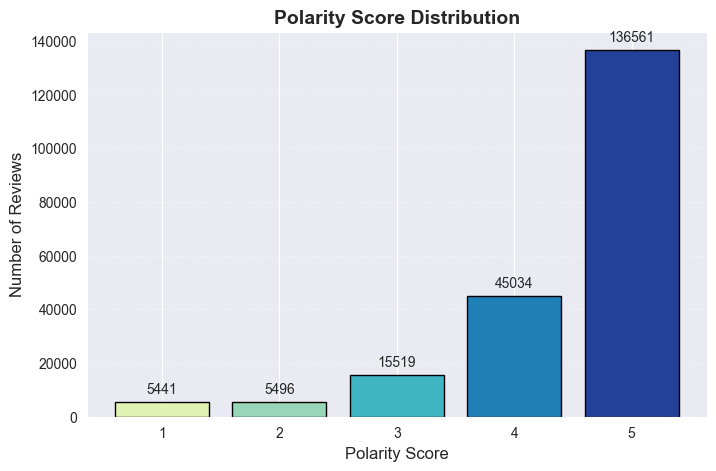

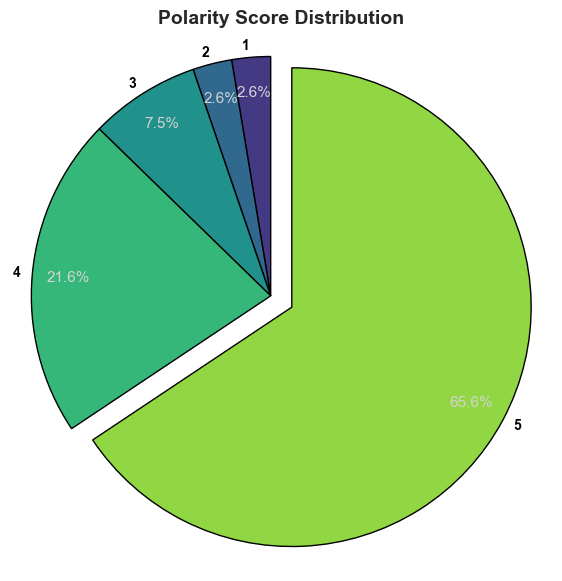

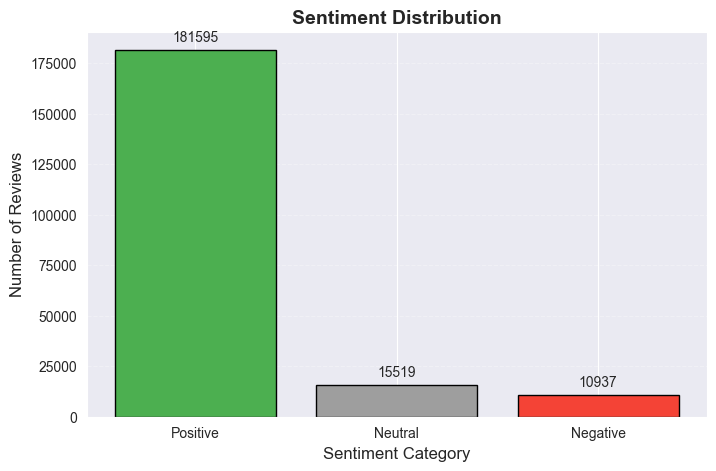

In [13]:
# Para graficar
pipeline.plot_polarity_histogram()
pipeline.plot_polarity_pie()
pipeline.plot_sentiment_histogram()

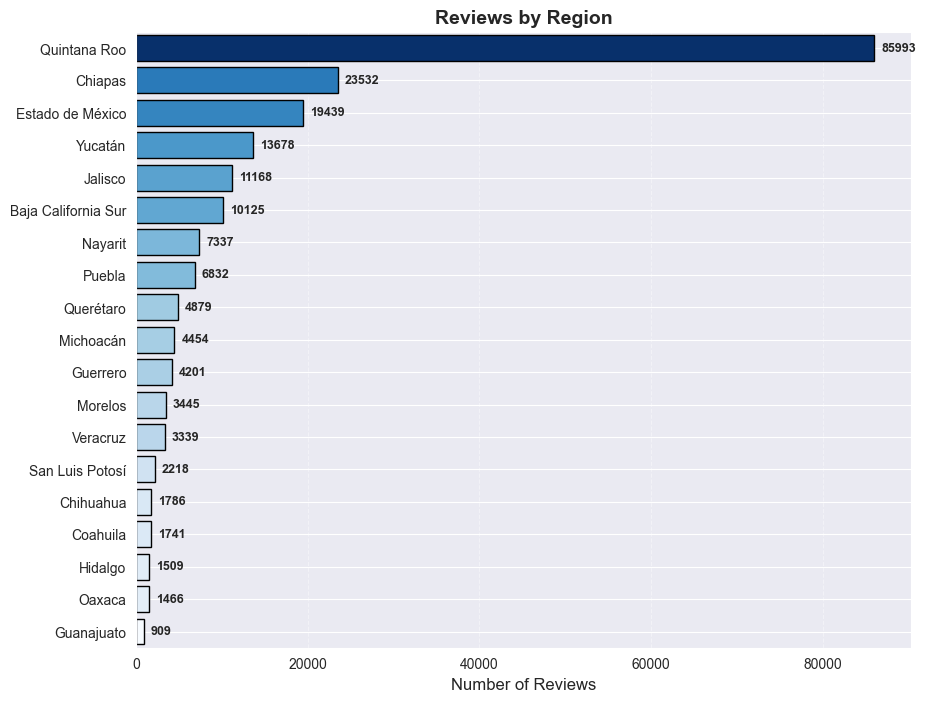

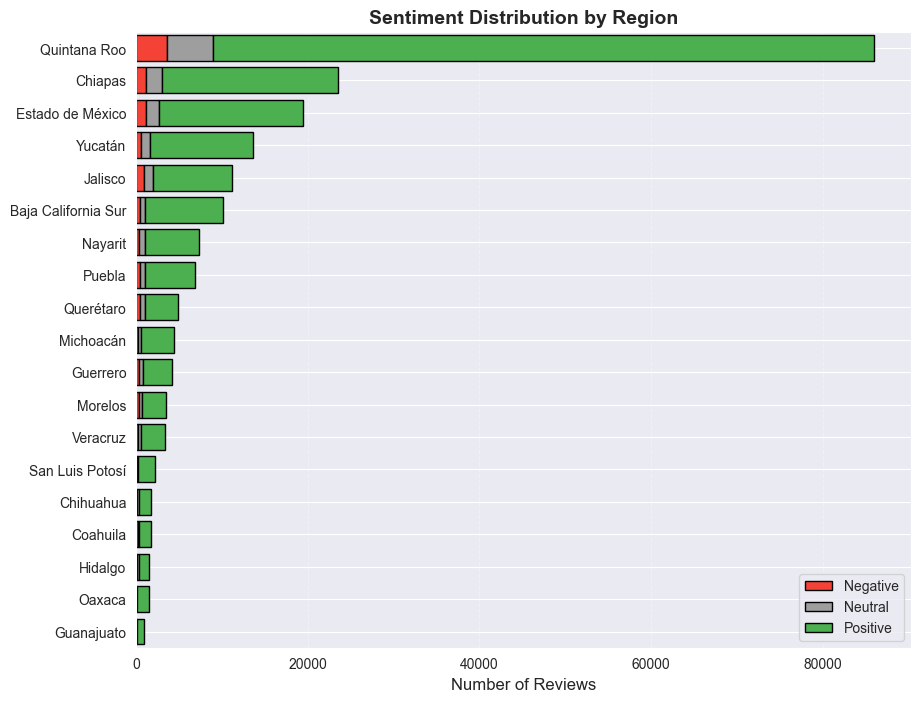

In [14]:
pipeline.plot_region_histogram()
pipeline.plot_sentiment_by_region()

In [15]:
print(Counter([int(p[0]) for p in pipeline.labels]))
print(Counter([p[1] for p in pipeline.labels]))
print(Counter([p[2] for p in pipeline.labels]))
#pipeline.labels

Counter({5: 136561, 4: 45034, 3: 15519, 2: 5496, 1: 5441})
Counter({'Tulum': 45345, 'Isla_Mujeres': 29826, 'San_Cristobal_de_las_Casas': 13060, 'Valladolid': 11637, 'Bacalar': 10822, 'Palenque': 9512, 'Sayulita': 7337, 'Valle_de_Bravo': 5959, 'Teotihuacan': 5810, 'Loreto': 5525, 'TodosSantos': 4600, 'Patzcuaro': 4454, 'Taxco': 4201, 'Tlaquepaque': 4041, 'Ajijic': 3752, 'Tequisquiapan': 3627, 'Metepec': 3532, 'Tepoztlan': 3445, 'Cholula': 2790, 'Tequila': 2650, 'Orizaba': 2521, 'Izamal': 2041, 'Creel': 1786, 'Ixtapan_de_la_Sal': 1696, 'Zacatlan': 1602, 'Huasca_de_Ocampo': 1509, 'Mazunte': 1466, 'Xilitla': 1458, 'Atlixco': 1444, 'Malinalco': 1429, 'Bernal': 1252, 'Tepotzotlan': 1013, 'Cuetzalan': 996, 'Chiapa_de_Corzo': 960, 'Parras': 953, 'Dolores_Hidalgo': 909, 'Coatepec': 818, 'Cuatro_Cienegas': 788, 'Real_de_Catorce': 760, 'Tapalpa': 725})
Counter({'Restaurant': 86720, 'Attractive': 69921, 'Hotel': 51410})


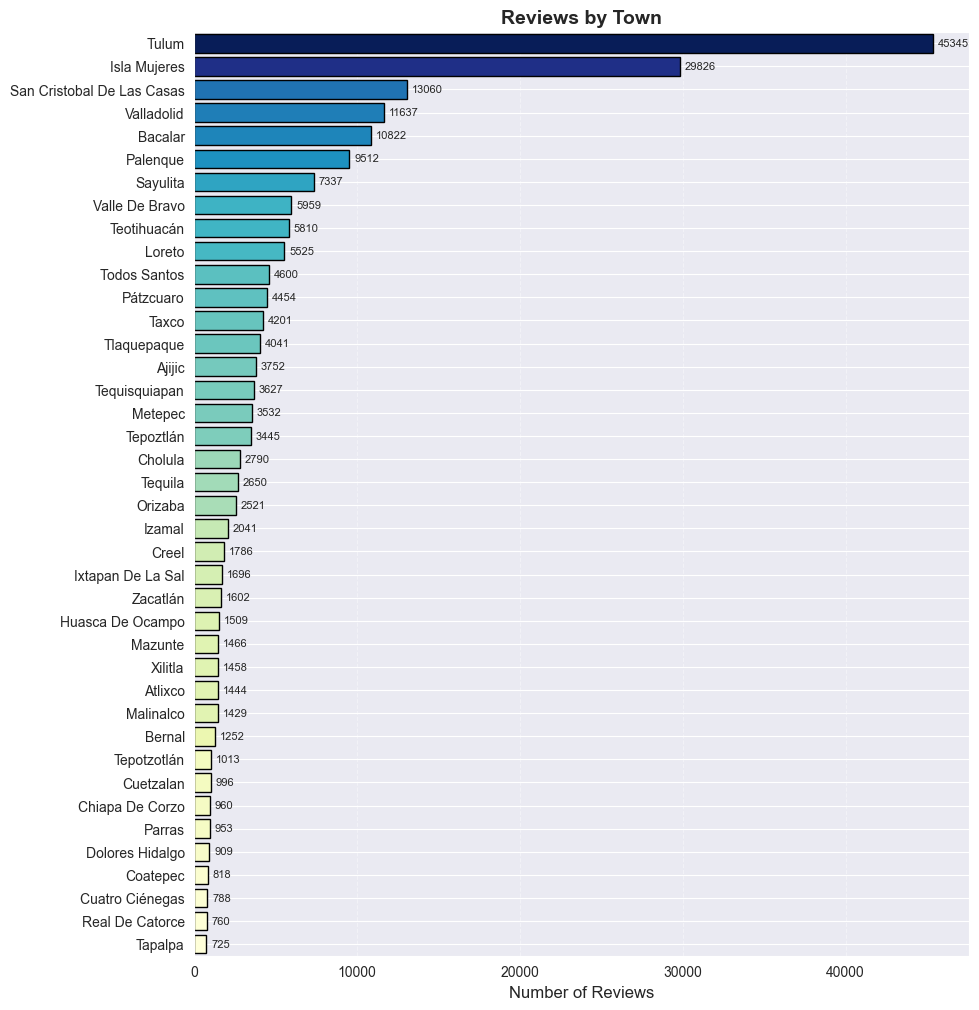

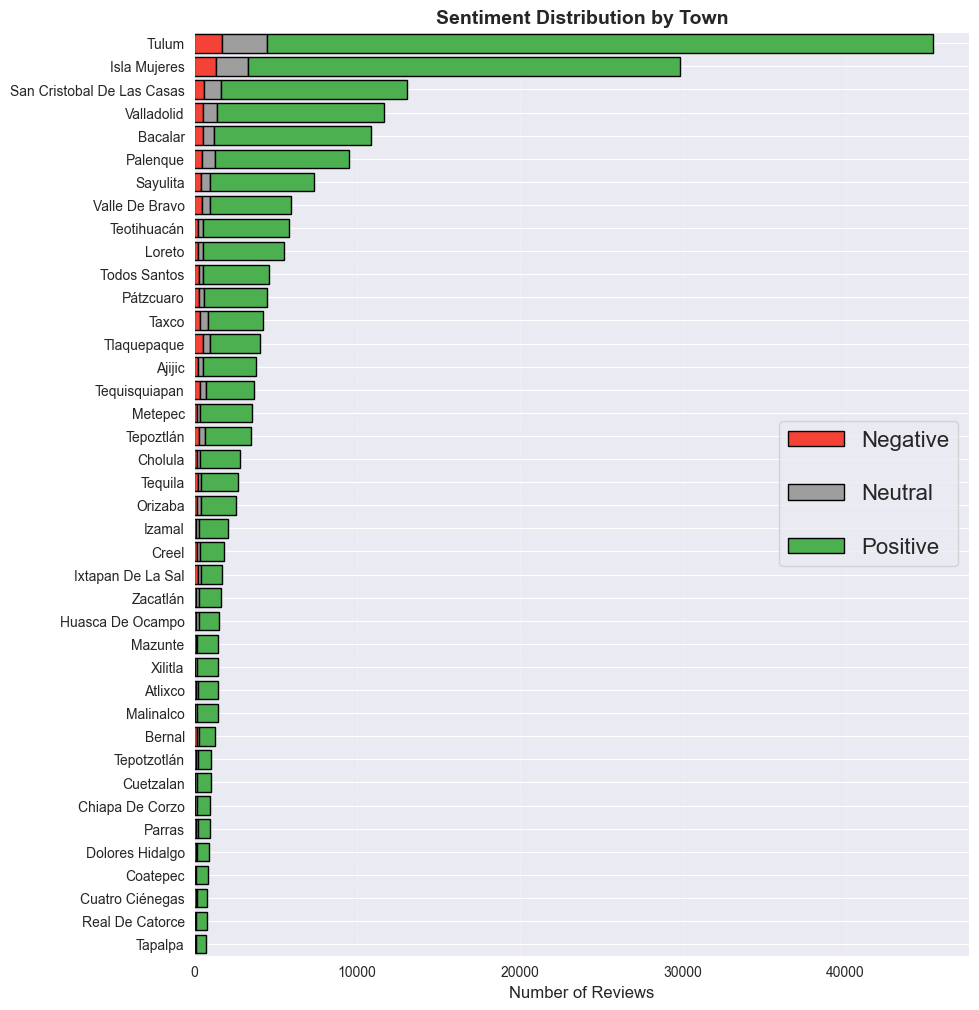

In [16]:
pipeline.plot_town_histogram()
pipeline.plot_sentiment_by_town()

In [17]:
#pipeline.plot_general_wordcloud(method = 'mi', label_type = 'Town', k = 50)

In [18]:
#pipeline.plot_class_representative_wordcloud(class_label = 'Xilitla', label_type = 'Town', k = 60)

## **DATALOADER**

In [19]:
train_dataloader = DataLoader(
    pipeline.train_dataset,
    batch_size=8,  # <- 8 pueblos por batch
    shuffle=True,
    collate_fn=collate_fn_hierarchical
)
val_dataloader = DataLoader(
    pipeline.val_dataset,
    batch_size=8,  # número de pueblos por batch
    shuffle=False,
    collate_fn=collate_fn_hierarchical
)

In [20]:
batch = next(iter(train_dataloader))
print("Train batch shape :", batch[0].shape)
print("Labels shape      :", batch[1].shape)

Train batch shape : torch.Size([7, 2, 10000])
Labels shape      : torch.Size([7, 2])


# **MODELO**

In [32]:
class HierarchicalMultiTaskModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size,
                 num_polarities=5, num_types=3, num_towns=40,
                 embedding_matrix=None):
        super().__init__()

        # Word embeddings
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(embedding_matrix)
            self.embedding.weight.requires_grad = False  # o True si quieres entrenarla

        # Nivel palabra (por reseña)
        self.word_rnn = nn.GRU(embed_dim, hidden_size, batch_first=True, bidirectional=True)
        self.word_attn = nn.Linear(hidden_size * 2, 1)

        # Nivel reseña (por pueblo)
        self.sent_rnn = nn.GRU(hidden_size * 2, hidden_size, batch_first=True, bidirectional=True)
        self.sent_attn = nn.Linear(hidden_size * 2, 1)

        # Cabezas de salida
        self.polarity_fc = nn.Linear(hidden_size * 2, num_polarities)    # salida por reseña
        self.type_fc = nn.Linear(hidden_size * 2, num_types)             # salida por reseña
        self.town_fc = nn.Linear(hidden_size * 2, num_towns)             # salida por pueblo

    def forward(self, input_ids, lengths):
        batch_size, n_reviews, n_tokens = input_ids.size()
    
        # Reescalar para el nivel palabra
        input_ids = input_ids.view(-1, n_tokens)  # (B * R, T)
        lengths = lengths.view(-1)                # (B * R)
        input_ids = input_ids.long()
    
        # Filtrar reseñas con length > 0 para el nivel palabra
        valid_mask = lengths > 0
        valid_input_ids = input_ids[valid_mask]
        valid_lengths = lengths[valid_mask]
    
        embedded = self.embedding(valid_input_ids)
    
        packed = nn.utils.rnn.pack_padded_sequence(
            embedded, valid_lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        word_output, _ = self.word_rnn(packed)
        word_output, _ = nn.utils.rnn.pad_packed_sequence(word_output, batch_first=True)
    
        # Cortar input_ids válidos
        valid_input_ids = valid_input_ids[:, :word_output.size(1)]
    
        # Atención a nivel palabra
        attn_mask = (valid_input_ids != 0)
        attn_weights = self.word_attn(word_output).squeeze(-1)
        attn_weights = attn_weights.masked_fill(~attn_mask, -1e9)
        attn_weights = torch.softmax(attn_weights, dim=1).unsqueeze(1)
        valid_review_repr = torch.bmm(attn_weights, word_output).squeeze(1)  # (num_valid_reviews, 2H)
    
        # Ahora necesitamos reconstruir el tensor original (incluyendo dummies)
        device = input_ids.device
        review_repr = torch.zeros((batch_size * n_reviews, valid_review_repr.shape[-1]), device=device)
        review_repr[valid_mask] = valid_review_repr
    
        # Nivel reseña (por pueblo)
        review_repr = review_repr.view(batch_size, n_reviews, -1)  # (B, R, 2H)
        sent_output, _ = self.sent_rnn(review_repr)  # (B, R, 2H)
    
        # Atención a nivel reseña
        sent_attn_weights = self.sent_attn(sent_output).squeeze(-1)  # (B, R)
        sent_attn_weights = torch.softmax(sent_attn_weights, dim=1).unsqueeze(1)
        town_repr = torch.bmm(sent_attn_weights, sent_output).squeeze(1)  # (B, 2H)
    
        # Predicciones
        #flat_sent_output = sent_output.view(-1, sent_output.shape[-1])  # (B*R, 2H)
        flat_sent_output = sent_output.reshape(-1, sent_output.shape[-1])
        polarity_logits = self.polarity_fc(flat_sent_output).view(batch_size, n_reviews, -1)
        type_logits = self.type_fc(flat_sent_output).view(batch_size, n_reviews, -1)
        town_logits = self.town_fc(town_repr)
    
        return polarity_logits, type_logits, town_logits
   

In [33]:
class Trainer:
    def __init__(
            self, model: nn.Module, epochs: int, train_dataset: Dataset, train_dataloader: DataLoader,
            val_dataloader: DataLoader, device: str, lr: float, patience: int = 3,
            weight_decay: float = 1e-4, betas: Tuple[float, float] = (0.9, 0.999),
            lr_patience: int = 3, lr_factor: float = 0.1, checkpoint_path: str = 'trained_model',
            checkpoint_filename: str = 'checkpoint.pth', best_model_filename: str = 'best_model.pth'
    ):
        """
        Initialize the Trainer class.
        
        Parameters
        ----------
        model : nn.Module
            The model to be trained.
        epochs : int
            Number of epochs for training.
        train_dataset : Dataset
            The training dataset.
        train_dataloader : DataLoader
            DataLoader for the training dataset.
        val_dataloader : DataLoader
            DataLoader for the validation dataset.
        device : str
            The device to be used for training (CPU or GPU).
        lr : float, optional
            Learning rate for the optimizer. Default is 1e-3.
        patience : int, optional
            Number of epochs with no improvement after which training will be stopped. Default is 3.
        weight_decay : float, optional
            Weight decay for the optimizer. Default is 1e-4.
        betas : tuple, optional
            Betas for the optimizer. Default is (0.9, 0.999).
        lr_patience : int, optional
            Number of epochs with no improvement after which learning rate will be reduced. Default is 3.
        lr_factor : float, optional
            Factor by which the learning rate will be reduced. Default is 0.1.
        checkpoint_path : str, optional
            Path to save the checkpoint. Default is 'trained_model'.
        checkpoint_filename : str, optional
            Filename for the checkpoint. Default is 'checkpoint.pth'.
        best_model_filename : str, optional
            Filename for the best model. Default is 'best_model.pth'.
        """
        # Initialize the trainer.
        self.model = model.to(device)
        self.epochs = epochs
        self.train_dataset = train_dataset
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.device = device
        self.patience = patience

        # Checkpoint parameters.
        self.checkpoint_path     = checkpoint_path
        self.checkpoint_filename = checkpoint_filename
        self.best_model_filename = best_model_filename

        # Training metadata.
        self.train_loss_history = []   # Training loss history.
        self.val_loss_history   = []   # Validation loss history.
        self.f1_history         = []   # f1 metric history for country.
        self.best_val_f1        = 0    # Best f1 metric in validation set.
        self.n_no_improvement   = 0    # Number of epochs without improvement.
        self.best_state_dict    = None # Store the best model state dict.

        # Optimizer.
        self.optimizer   = optim.Adam(           
            params       = model.parameters(), # parameters to optimize.
            lr           = lr,                 # learning rate.
            weight_decay = weight_decay,       # weight decay.
            betas        = betas               # betas for the optimizer.
        )

        # Scheduler.
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau( 
            optimizer  = self.optimizer, # optimizer to adjust.
            mode       = 'min',          # mode (min means reduce when the quantity monitored has stopped decreasing).
            patience   = lr_patience,    # patience (number of epochs with no improvement after which learning rate will be reduced).
            factor     = lr_factor       # factor by which the learning rate will be reduced. new_lr = lr * factor.
        )

        # Loss function for classification.
        self.criterion = nn.CrossEntropyLoss()

    def eval_model(self, dataloader: DataLoader) -> dict:
        """
        Evaluates the multitask model.

        Parameters
        ----------
        dataloader : DataLoader
            DataLoader for the evaluation dataset.

        Returns
        -------
        dict
            Dictionary containing the loss, f1 score, scores, predictions and targets.
        """
        with torch.no_grad():
            self.model.eval() # Set the model to evaluation mode.
            
            losses = []                         # List to store the losses.
            preds, targets, scores = [], [], [] # List to store the predictions, targets and scores for country.
    
            # Iterate over the batches.
            for inputs, labels in tqdm(dataloader, desc = 'Evaluation... ', colour = 'blue'):
                torch.cuda.empty_cache() # Clear the cache.
                inputs, labels = inputs.to(self.device), labels.to(self.device)
    
                # Forward pass.
                logits, _, _ = self.model(inputs) # Output of the model.

                # Calculate the loss for the batch.
                loss_per_batch = self.criterion(logits, labels)
                losses.append(loss_per_batch.item())

                # Predictions and targets.
                pred = logits.argmax(dim = 1) # Predicted class for country

                # Append predictions and true labels to the lists.
                preds += pred.cpu().tolist()
                targets += labels.cpu().tolist()

                # Probabilities using softmax (for score/confidence tracking)
                probs = torch.softmax(logits, dim = 1)
                scores += probs[torch.arange(len(pred)), pred].cpu().tolist()

            # F1 scores
            f1 = f1_score(targets, preds, average = 'macro') # For multi-class classification.

            return {
                'loss'    : np.mean(losses),
                'f1'      : f1,
                'scores'  : scores,
                'preds'   : preds,
                'targets' : targets,
                }

    def train(self):
        """
        Train the model.
        """
        start_time = time.time() # Start time of the training.

        for epoch in range(1, self.epochs + 1):
            self.model.train()
            loss_train = 0
            epoch_time = time.time() # Start time of the epoch.
    
            for inputs, labels in tqdm(self.train_dataloader, desc = 'Training... ', colour = 'green'):
                torch.cuda.empty_cache()   # Clear the cache.       
                self.optimizer.zero_grad() # Zero the gradients.
    
                inputs, labels = inputs.to(self.device), labels.to(self.device)
    
                logits, _, _ = self.model(inputs) # Forward pass.
    
                # Calculate the loss for the batch.
                loss_per_batch = self.criterion(logits, labels)
    
                # Backward pass and optimization.
                loss_per_batch.backward()
                self.optimizer.step()
                loss_train += loss_per_batch.item()
    
            # Average loss for the epoch.
            loss_train /= len(self.train_dataloader)
    
            # Evaluate the model on the validation set.
            val_results = self.eval_model(self.val_dataloader)
            val_loss    = val_results['loss']
            val_f1      = val_results['f1']

            # Store the results.
            self.train_loss_history.append(loss_train)
            self.val_loss_history.append(val_loss)
            self.f1_history.append(val_f1)
    
            # Sum of F1 scores to determine the best model.
            is_improvement = val_f1 > self.best_val_f1
            
            if is_improvement:
                self.best_val_f1 = val_f1
                self.best_time = time.time() - start_time
                self.best_epoch = epoch
                self.n_no_improvement = 0
            else:
                self.n_no_improvement += 1

            # Save checkpoint.
            elapsed_time = time.time() - start_time # Elapsed time since the start of training.
            self.save_checkpoint(
                state = {
                    # This epoch information.
                    'epoch'              : epoch,
                    'state_dict'         : self.model.state_dict(),
                    'loss_train'         : loss_train,
                    'loss_val'           : val_loss,
                    'elapsed_time'       : elapsed_time,
                    # Best information.
                    'best_val_f1'        : self.best_val_f1,
                    'best_epoch'         : self.best_epoch,
                    'best_time'          : self.best_time,
                    # History information.
                    'train_loss_history' : self.train_loss_history,
                    'val_loss_history'   : self.val_loss_history,
                    'f1_history'         : self.f1_history,
                },
                is_best = is_improvement
            )

            # Early stopping.
            if self.n_no_improvement >= self.patience:
                tqdm.write(f"{Fore.RED}Early stopping triggered at epoch {epoch}!{Style.RESET_ALL}")
                break
            elif loss_train < 1e-5:
                tqdm.write(f"{Fore.RED}Loss is too low, stopping training!{Style.RESET_ALL}")
                break
    
            # Print the results.
            tqdm.write(f"{Style.BRIGHT}{Fore.CYAN} Epoch{epoch:>3}/{self.epochs}{Style.RESET_ALL}"
                       f"  ➤ Training loss: {Fore.GREEN}{loss_train:.6f}{Style.RESET_ALL} | "
                       f"Validation Loss: {Fore.YELLOW}{val_loss:.6f}{Style.RESET_ALL} | "
                       f"F1: {Fore.MAGENTA}{val_f1:.6f}{Style.RESET_ALL} | "
                       f"Epoch Time: {time.time() - epoch_time:.2f} s | "
                       f"Total Time: {elapsed_time:.2f} s")
            
        print(f"\n{Style.BRIGHT}--- Total Training Time: {elapsed_time:.2f} seconds ---{Style.RESET_ALL}")

    def save_checkpoint(self, state: dict, is_best: bool) -> None:
        """
        Save a checkpoint of the model, including the state dictionary, training metadata,
        optimizer state, and the initialization parameters used to construct the model.

        Parameters
        ----------
        state : dict
            Dictionary with the model state, best model state, loss histories, and optimizer state.
        is_best : bool
            If True, also save the model as the best checkpoint.
        """
        if not os.path.exists(self.checkpoint_path):
            os.makedirs(self.checkpoint_path, exist_ok = True)

        if is_best:
            state['best_model_state_dict'] = self.model.state_dict()

        filepath = os.path.join(self.checkpoint_path, self.checkpoint_filename)
        torch.save(state, filepath)

        if is_best:
            best_path = os.path.join(self.checkpoint_path, self.best_model_filename)
            torch.save({'best_model_state_dict': self.model.state_dict()}, best_path)

    def plot_metrics(self):
        """
        Plot the training and validation loss and F1 score over epochs.
        """
        epochs = list(range(1, len(self.train_loss_history) + 1))
    
        fig, axes = plt.subplots(1, 2, figsize = (16,6)) 
    
        # Loss plot.
        axes[0].plot(epochs, self.train_loss_history, label = 'Training Loss', color = '#1f77b4')
        axes[0].plot(epochs, self.val_loss_history, label = 'Validation Loss', color = '#ff7f0e')
        axes[0].axvline(self.best_epoch, linestyle = "--", color = "gray", alpha = 0.7, label = f"Best Epoch: {self.best_epoch}")
        axes[0].set_title('Loss over Epochs', fontsize = 14, fontweight = 'bold')
        axes[0].set_xlabel('Epochs', fontsize = 12)
        axes[0].set_ylabel('Loss', fontsize = 12)
        axes[0].legend(fontsize = 12)
        axes[0].grid(True)
    
        # F1 Score plot.
        axes[1].plot(epochs, self.f1_history, label = 'F1', color = '#d62728')
        axes[1].axvline(self.best_epoch, linestyle = "--", color = "gray", alpha = 0.7, label = f"Best Epoch: {self.best_epoch}")
        axes[1].set_title('F1 Score over Epochs', fontsize = 14, fontweight = 'bold')
        axes[1].set_xlabel('Epochs', fontsize = 12)
        axes[1].set_ylabel('F1 Score', fontsize = 12)
        axes[1].legend(fontsize = 12)
        axes[1].grid(True)
    
        plt.tight_layout()
        plt.show()

In [37]:
class MultiTaskTrainer(Trainer):
    def __init__(self, *args, type2id: dict, town2id: dict, loss_weights=(2, 1, 3), **kwargs):
        super().__init__(*args, **kwargs)

        # Ponderación de tareas: (polarity, type, town)
        self.loss_weights = loss_weights
        self.type2id = type2id
        self.town2id = town2id
        self.criterion_polarity = nn.CrossEntropyLoss(ignore_index=-1)
        self.criterion_type = nn.CrossEntropyLoss(ignore_index=-1)  # También para types
        self.criterion_town = nn.CrossEntropyLoss()  # No cambia aquí

    def compute_loss(self, polarity_logits, type_logits, town_logits,
                     polarity_targets, type_targets, town_targets):
        loss_p = self.criterion_polarity(polarity_logits.view(-1, polarity_logits.size(-1)), polarity_targets.view(-1))
        loss_t = self.criterion_type(type_logits.view(-1, type_logits.size(-1)), type_targets.view(-1))
        loss_m = self.criterion_town(town_logits, town_targets)
        return self.loss_weights[0] * loss_p + self.loss_weights[1] * loss_t + self.loss_weights[2] * loss_m

    def eval_model(self, dataloader):
        self.model.eval()
        all_preds = []
        all_targets = []
        losses = []

        with torch.no_grad():
            for input_ids, lengths, polarities, types, towns in tqdm(dataloader, desc="Eval", colour="blue"):
                input_ids = input_ids.to(self.device)
                lengths = lengths.to(self.device)
                polarities = polarities.to(self.device)

                polarity_logits, type_logits, town_logits = self.model(input_ids, lengths)

                # Asume que ya tienes mapeos type2id y town2id (usa torch.tensor())
                type_ids = torch.tensor([[self.type2id.get(t, 0) for t in row] for row in types], device=self.device)
                town_ids = torch.tensor([self.town2id.get(town, 0) for town in towns], device=self.device)

                loss = self.compute_loss(
                    polarity_logits, type_logits, town_logits,
                    (polarities.long() - 1),  # << aquí haces el shift
                    type_ids,
                    town_ids
                )
                losses.append(loss.item())

                preds = polarity_logits.argmax(dim=-1).view(-1).cpu().tolist()
                targets = polarities.view(-1).cpu().tolist()

                all_preds.extend(preds)
                all_targets.extend(targets)

        f1 = f1_score(all_targets, all_preds, average='macro')
        return {'loss': np.mean(losses), 'f1': f1}

    def train(self):
        start_time = time.time()

        for epoch in range(1, self.epochs + 1):
            self.model.train()
            total_loss = 0

            for input_ids, lengths, polarities, types, towns in tqdm(self.train_dataloader, desc=f"Train Epoch {epoch}", colour="green"):
                self.optimizer.zero_grad()

                input_ids = input_ids.to(self.device)
                lengths = lengths.to(self.device)
                polarities = polarities.to(self.device)

                polarity_logits, type_logits, town_logits = self.model(input_ids, lengths)

                type_ids = torch.tensor([[self.type2id.get(t, 0) for t in row] for row in types], device=self.device)
                town_ids = torch.tensor([self.town2id.get(town, 0) for town in towns], device=self.device)

                #loss = self.compute_loss(polarity_logits, type_logits, town_logits,
                #                         polarities.long(), type_ids, town_ids)
                loss = self.compute_loss(
                    polarity_logits, type_logits, town_logits,
                    (polarities.long() - 1),  # << aquí haces el shift
                    type_ids,
                    town_ids
                )
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / len(self.train_dataloader)
            val_results = self.eval_model(self.val_dataloader)

            self.train_loss_history.append(avg_loss)
            self.val_loss_history.append(val_results['loss'])
            self.f1_history.append(val_results['f1'])

            # Control de mejor modelo y early stopping
            is_best = val_results['f1'] > self.best_val_f1
            if is_best:
                self.best_val_f1 = val_results['f1']
                self.best_state_dict = self.model.state_dict()
                self.n_no_improvement = 0
            else:
                self.n_no_improvement += 1

            self.save_checkpoint({'epoch': epoch, 'state_dict': self.model.state_dict()}, is_best)

            tqdm.write(f"Epoch {epoch}: Train Loss = {avg_loss:.4f}, Val Loss = {val_results['loss']:.4f}, Val F1 = {val_results['f1']:.4f}")

            if self.n_no_improvement >= self.patience:
                tqdm.write("Early stopping!")
                break


In [38]:
embedding_matrix = torch.tensor(pipeline.emb_mat, dtype=torch.float)
model = HierarchicalMultiTaskModel(
    vocab_size = pipeline.emb_mat.shape[0],
    embed_dim = embedding_matrix.shape[1],
    hidden_size=128,  # o el que prefieras
    num_polarities=5,
    num_types=len(pipeline.type2id),
    num_towns=len(pipeline.town2id),
    embedding_matrix=embedding_matrix
)
trainer = MultiTaskTrainer(
    model=model,
    epochs=2,
    train_dataset=pipeline.train_dataset,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    lr=1e-3,
    patience=3,
    type2id=pipeline.type2id,
    town2id=pipeline.town2id
)

In [39]:
trainer.train()

Eval: 100%|██████████| 5202/5202 [01:20<00:00, 64.82it/s]


Epoch 1: Train Loss = 6.4568, Val Loss = 5.9375, Val F1 = 0.1355


Train Epoch 2:   2%|▏         | 477/20805 [00:17<12:34, 26.94it/s]


KeyboardInterrupt: 